In [1]:
import glob
import inspect

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

from astropy.io import fits
from astropy.time import Time

# The data set
Set the directory to the appropriate location.

In [5]:
#files = glob.glob("C:/Users/ayshih/Downloads/moxsi_fm_build/*.fits")
files = glob.glob('../data/moxsi_gsfc_calibration_images/csie_image_*.fits')
files.sort()

In [6]:
# Skip the first file due to uncertainty in the true exposure time
files = files[1:]

In [7]:
# There should be 4598 files
len(files), files[0], files[-1]

(4598,
 '../data/moxsi_gsfc_calibration_images/csie_image_20250930_182227_067127_frame53598.bin.fits',
 '../data/moxsi_gsfc_calibration_images/csie_image_20251001_205720_079582_frame58195.bin.fits')

# The temperature-conversion functions
The DN for each temperature needs to be converted to a physical value.  There are two functions: a polynomial function and a Steinhart-Hart function.  We will always use the latter because it is supposed to be more accurate.

In [8]:
# These are the polynomial functions, but we won't use them
det0temp_poly = np.poly1d([-9.270400e-16, 9.978400e-12, -4.346300e-08, 9.685700e-05, -1.339600e-01, 1.243100e+02])
det1temp_poly = np.poly1d([-9.390500e-16, 1.012500e-11, -4.417600e-08, 9.861100e-05, -1.362200e-01, 1.255500e+02])

fpgatemp_poly = np.poly1d([-9.390500e-16, 1.012500e-11, -4.417600e-08, 9.861100e-05, -1.362200e-01, 1.255500e+02])

thermadc_poly = np.poly1d([-8.242800e-16, 8.990900e-12, -4.055000e-08, 9.534600e-05, -1.430500e-01, 1.379100e+02])

In [9]:
# scale=True is for "det0", which is the detector temperature
def steinharthart(coeff, scale=False):
    def func(dn):
        r = dn / (4096 - dn)
        if scale:
            r *= 10000
        result = 1 / np.poly1d(coeff[::-1])(np.log(r)) - 273.15
        return result
    return func

In [10]:
# These are the Steinhart-Hart functions, which we will use
det0temp_sh = steinharthart([1.1292E-03, 2.3411E-04, 0.0000E+00, 8.7755E-08], scale=True)
det1temp_sh = steinharthart([3.3540E-03, 2.5708E-04, 1.8939E-06, 1.8973E-07])
fpgatemp_sh = steinharthart([3.3540E-03, 2.5708E-04, 1.8939E-06, 1.8973E-07])
thermadc_sh = steinharthart([3.3540E-03, 3.0013E-04, 5.0852E-06, 2.1877E-07])

# Read all of the images
For quick analysis, we can limit ourselves to a small handful of pixels.

In [11]:
nfiles = len(files)

#data = np.empty((nfiles, 2000, 1504))
subdata = np.empty((nfiles, 5, 4))
median = np.empty(nfiles)

hdu_time = np.empty(nfiles)
csie_time = np.empty(nfiles)
csie_frame_id = np.empty(nfiles)
exptime = np.empty(nfiles)
det0temp_dn = np.empty(nfiles)
det1temp_dn = np.empty(nfiles)
thermadc_dn = np.empty(nfiles)
fpgatemp_dn = np.empty(nfiles)

for i, file in enumerate(tqdm(files)):
    with fits.open(file) as f:
        hdu_time[i] = (Time(f[0].header["date"]) - Time('2025-09-30 18:00')).to('s').value
        csie_time[i] = f[0].header["SHCOARSE"] + f[0].header["SHFINE"] / 1000
        csie_frame_id[i] = f[0].header["frame_id"]
        exptime[i] = f[0].header["exptime"]

        #data[i, :, :] = f[0].data[:2000, :]  # sometimes the data has an extra row that should be disregarded
        subdata[i, :, :] = f[0].data[200::400, 188::376]
        median[i] = np.median(f[0].data[:2000, :])  # sometimes the data has an extra row that should be disregarded

        det0temp_dn[i] = f[0].header["det0temp"]
        det1temp_dn[i] = f[0].header["det1temp"]
        fpgatemp_dn[i] = f[0].header["fpgatemp"]
        thermadc_dn[i] = f[0].header["thermadc"]

  0%|          | 0/4598 [00:00<?, ?it/s]

# Process the metadata

In [12]:
# Convert to physical temperatures
det0temp = det0temp_sh(det0temp_dn)
det1temp = det1temp_sh(det1temp_dn)
fpgatemp = fpgatemp_sh(fpgatemp_dn)
thermadc = thermadc_sh(thermadc_dn)

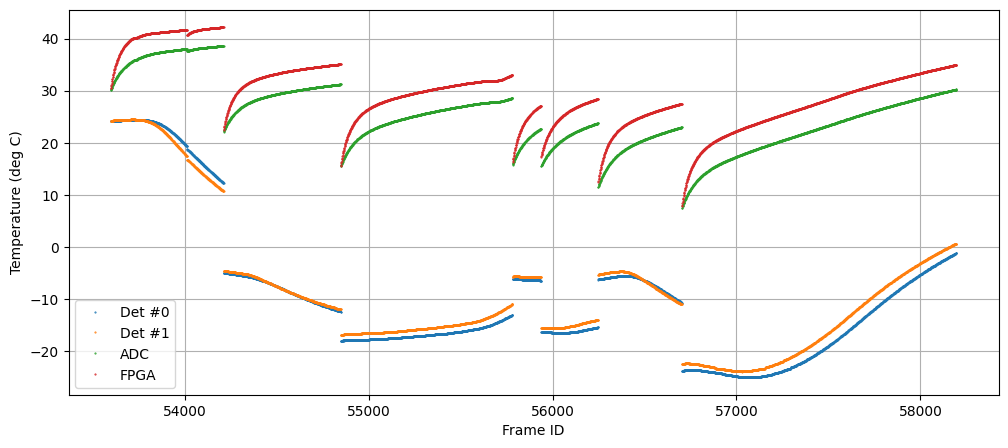

In [13]:
# Take a look at the temperatures
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()

ax.plot(csie_frame_id, det0temp, '.', markersize=1, label='Det #0')
ax.plot(csie_frame_id, det1temp, '.', markersize=1, label='Det #1')
ax.plot(csie_frame_id, thermadc, '.', markersize=1, label='ADC')
ax.plot(csie_frame_id, fpgatemp, '.', markersize=1, label='FPGA')

ax.grid()

ax.set_xlabel("Frame ID")
ax.set_ylabel("Temperature (deg C)")
ax.legend()

plt.show()

In [14]:
# Exposure times are lies!
exptime_fixed = np.empty_like(exptime)
exptime_fixed[:414] = np.where(exptime[:414] == 1250, 5000, 1250)
exptime_fixed[414:] = np.where(exptime[414:] == 2500, 1250, np.where(exptime[414:] == 5000, 2500, 5000))
exptime_fixed[614] = 5000  # this single image needs to be separately fixed

In [15]:
exp1250 = exptime_fixed == 1250
exp2500 = exptime_fixed == 2500
exp5000 = exptime_fixed == 5000

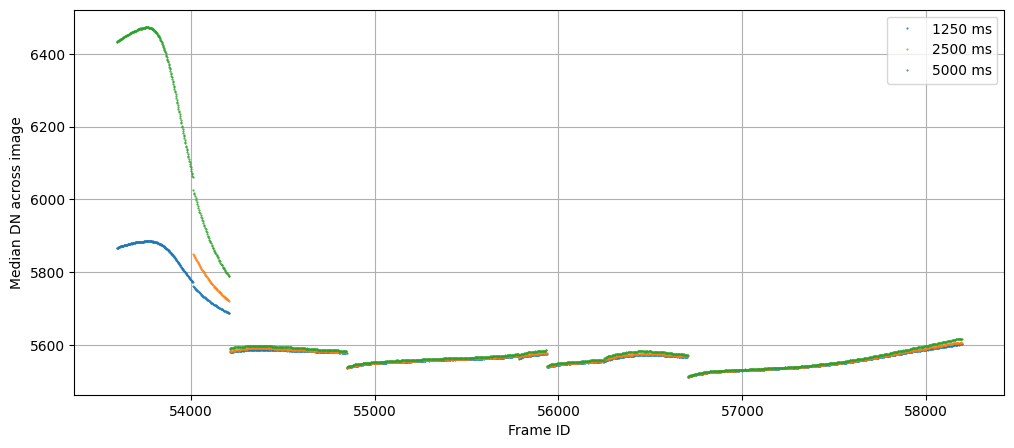

In [16]:
# Check that the exposure times are consistent with the ordering of median DNs
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()

ax.plot(csie_frame_id[exp1250], median[exp1250], '.', markersize=1, label='1250 ms')
ax.plot(csie_frame_id[exp2500], median[exp2500], '.', markersize=1, label='2500 ms')
ax.plot(csie_frame_id[exp5000], median[exp5000], '.', markersize=1, label='5000 ms')

ax.grid()

ax.set_xlabel("Frame ID")
ax.set_ylabel("Median DN across image")
ax.legend()

plt.show()

# View the behavior of the median pedestal

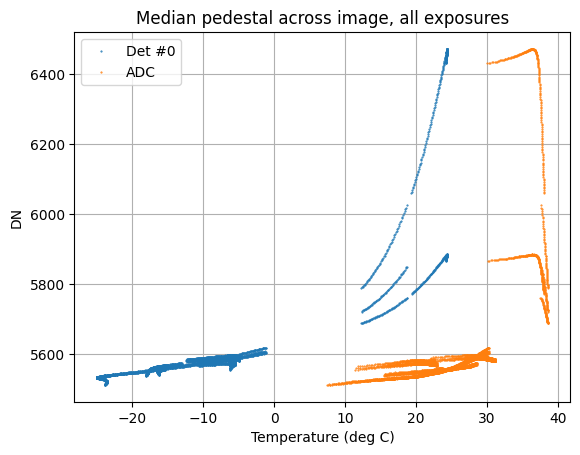

In [17]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(det0temp, median, '.', markersize=1, label='Det #0')
ax.plot(thermadc, median, '.', markersize=1, label='ADC')

ax.grid()

ax.set_title("Median pedestal across image, all exposures")
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("DN")
ax.legend()

plt.show()

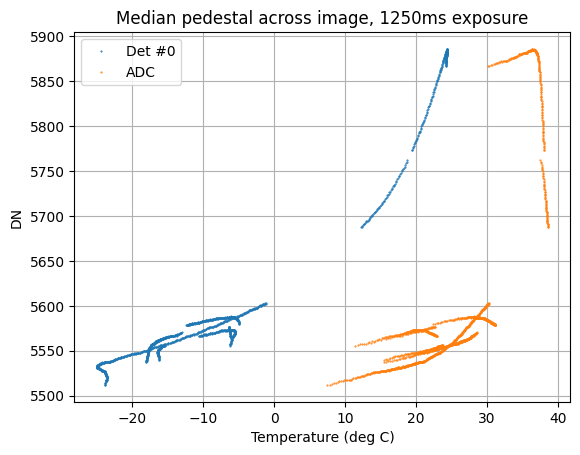

In [18]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(det0temp[exp1250], median[exp1250], '.', markersize=1, label='Det #0')
ax.plot(thermadc[exp1250], median[exp1250], '.', markersize=1, label='ADC')

ax.grid()

ax.set_title("Median pedestal across image, 1250ms exposure")
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("DN")
ax.legend()

plt.show()

# Define the pedestal model

In [19]:
# The input variables are detector temperature, ADC temperature, and exposure time
space3d = np.vstack((det0temp, thermadc, exptime_fixed))
space3d.shape  # should be (3, 4598)

(3, 4598)

In [20]:
# This is the pedestal model
def model(X, a, b, c, d, e, f):
    t_det0, t_adc, exposure = X
    return a + b * exposure * np.exp(t_det0 / c) + d * t_det0 + e * t_det0**2 + f * t_adc

# Test using this pedestal model on the image median

In [21]:
params1250 = curve_fit(model, space3d[:, exp1250], median[exp1250])[0]

In [22]:
predicts1250 = model(space3d[:, exp1250], *params1250)

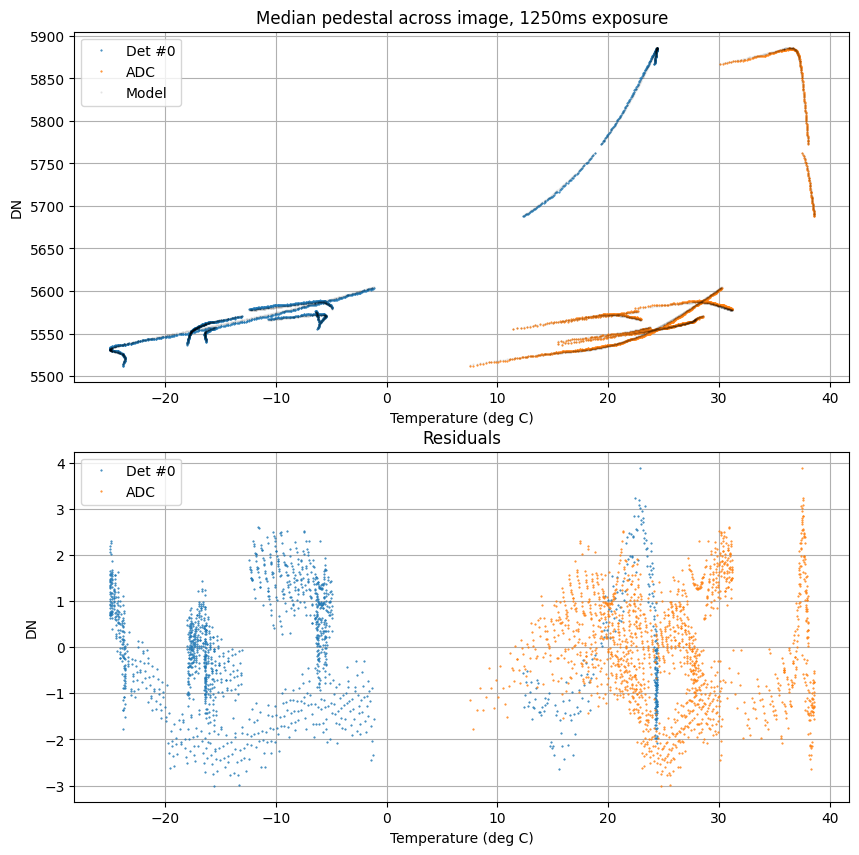

In [23]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(211)

ax.plot(det0temp[exp1250], median[exp1250], '.', markersize=1, label='Det #0')
ax.plot(thermadc[exp1250], median[exp1250], '.', markersize=1, label='ADC')

ax.plot(det0temp[exp1250], predicts1250, 'k.', markersize=1, alpha=0.1, label='Model')
ax.plot(thermadc[exp1250], predicts1250, 'k.', markersize=1, alpha=0.1, label='')

ax.grid()

ax.set_title("Median pedestal across image, 1250ms exposure")
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("DN")
ax.legend()

ax = fig.add_subplot(212)

ax.plot(det0temp[exp1250], median[exp1250] - predicts1250, '.', markersize=1, label='Det #0')
ax.plot(thermadc[exp1250], median[exp1250] - predicts1250, '.', markersize=1, label='ADC')

ax.grid()

ax.set_title("Residuals")
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("DN")
ax.legend()


plt.show()

In [24]:
params_all = curve_fit(model, space3d, median)[0]

In [25]:
predicts_all = model(space3d, *params_all)

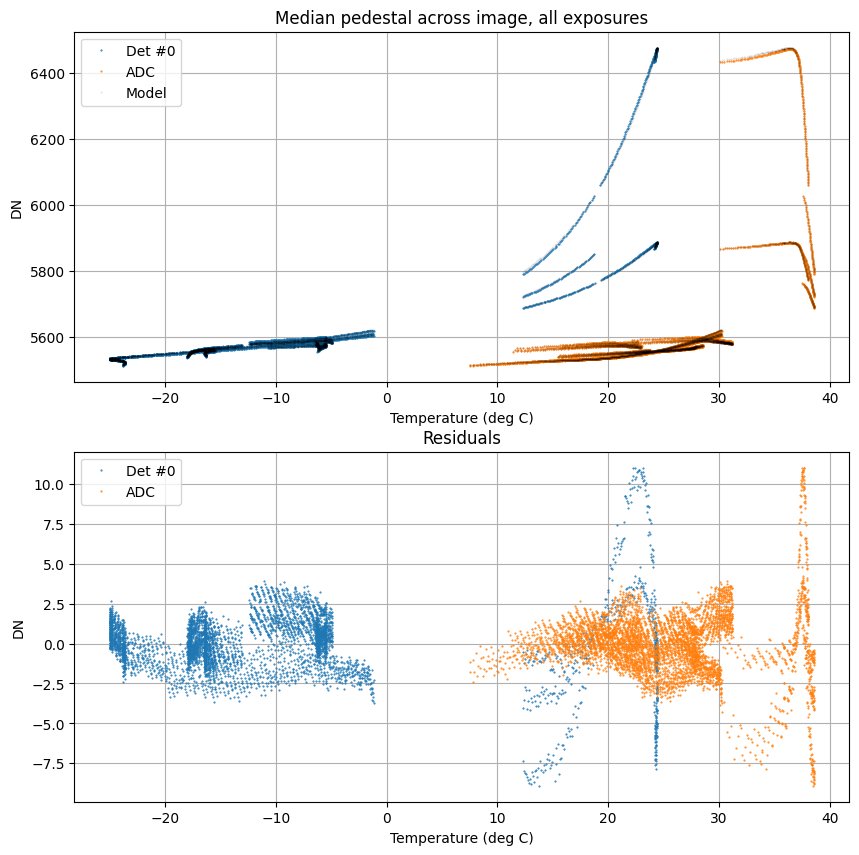

In [26]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(211)

ax.plot(det0temp, median, '.', markersize=1, label='Det #0')
ax.plot(thermadc, median, '.', markersize=1, label='ADC')

ax.plot(det0temp, predicts_all, 'k.', markersize=1, alpha=0.1, label='Model')
ax.plot(thermadc, predicts_all, 'k.', markersize=1, alpha=0.1, label='')

ax.grid()

ax.set_title("Median pedestal across image, all exposures")
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("DN")
ax.legend()

ax = fig.add_subplot(212)

ax.plot(det0temp, median - predicts_all, '.', markersize=1, label='Det #0')
ax.plot(thermadc, median - predicts_all, '.', markersize=1, label='ADC')

ax.grid()

ax.set_title("Residuals")
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("DN")
ax.legend()


plt.show()

# Test using this pedestal model on individual pixels

In [27]:
# Create an array to hold the model parameters for each of the pixels
params = np.empty((len(inspect.signature(model).parameters) - 1, *subdata.shape[1:]))
params.shape

(6, 5, 4)

In [28]:
for j in range(subdata.shape[2]):
    for i in range(subdata.shape[1]):
        params[:, i, j] = curve_fit(model, space3d, subdata[:, i, j])[0]
        with np.printoptions(linewidth=100, suppress=True):
            print(i, j, params[:, i, j])
    print()

0 0 [5610.34608851    0.00435593    7.23513352    2.4995671     0.02246195    1.96201899]
1 0 [5613.04295509    0.00477595    6.9605285     2.48961333    0.01826076    2.00354592]
2 0 [5630.45643177    0.00525104    7.00171973    2.58365168    0.01307477    1.90721336]
3 0 [5600.14026543    0.00485625    7.22656472    2.6389475     0.02279723    2.11758639]
4 0 [5675.54137291    0.00465637    6.99002687    2.50743191    0.01897106    1.90752978]

0 1 [5604.83171562    0.0047185     7.26011724    2.70189046    0.02488998    2.03101424]
1 1 [5588.42904       0.00524779    7.07161983    2.77621387    0.02546155    2.00880667]
2 1 [5602.5304131     0.005451      7.13204339    2.78128271    0.02361475    2.02624719]
3 1 [5630.93482896    0.00489153    7.16818442    2.72123423    0.01985736    1.98421786]
4 1 [5660.39954401    0.00488008    6.9998318     2.81676233    0.01736657    2.04432462]

0 2 [5409.17351912    0.00521156    7.16166559    3.01758279    0.02001375    2.39273574]
1 2 [544

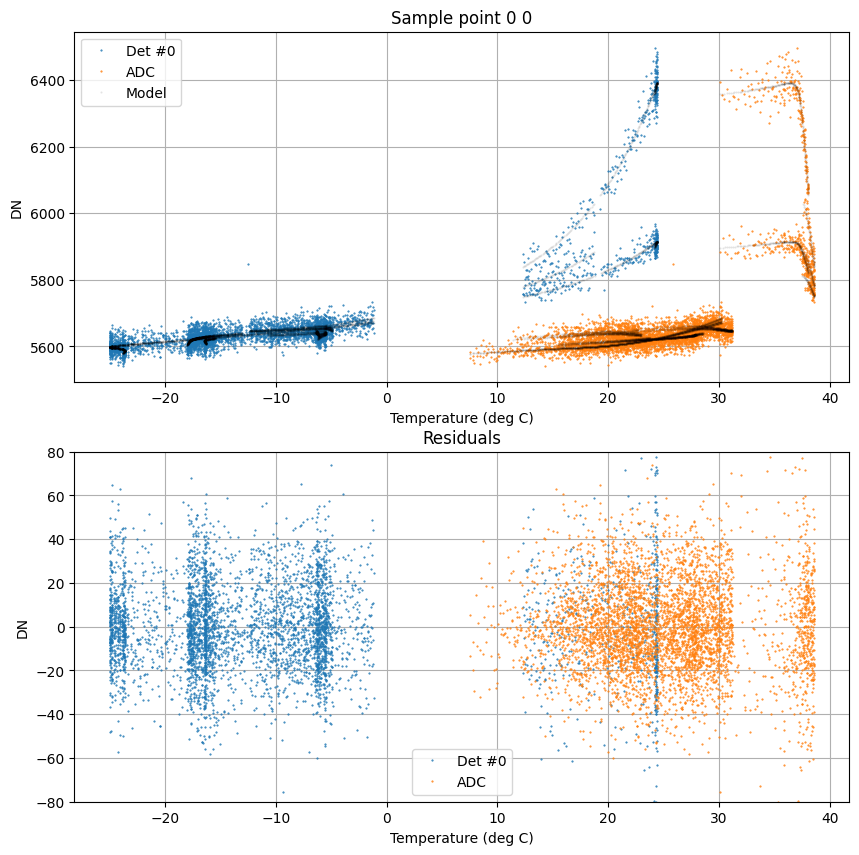

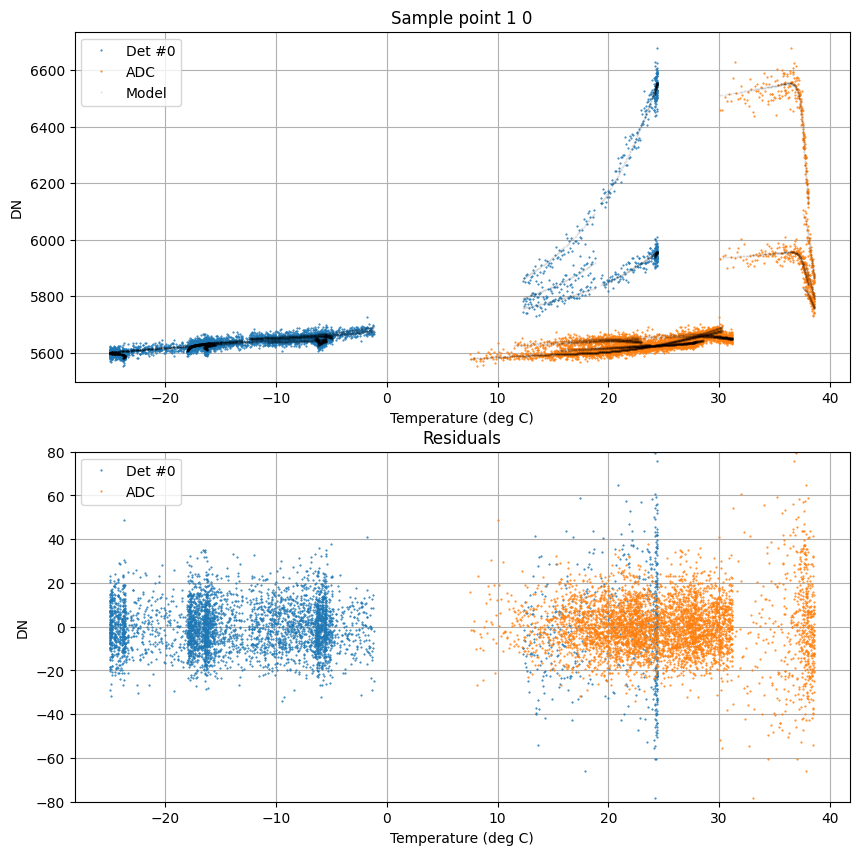

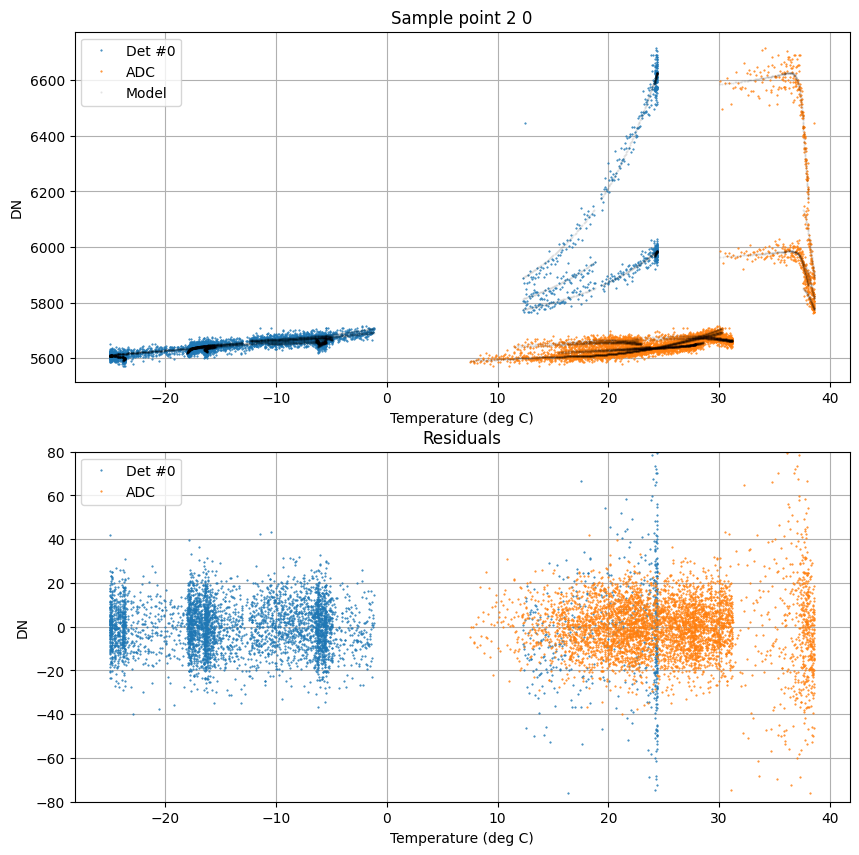

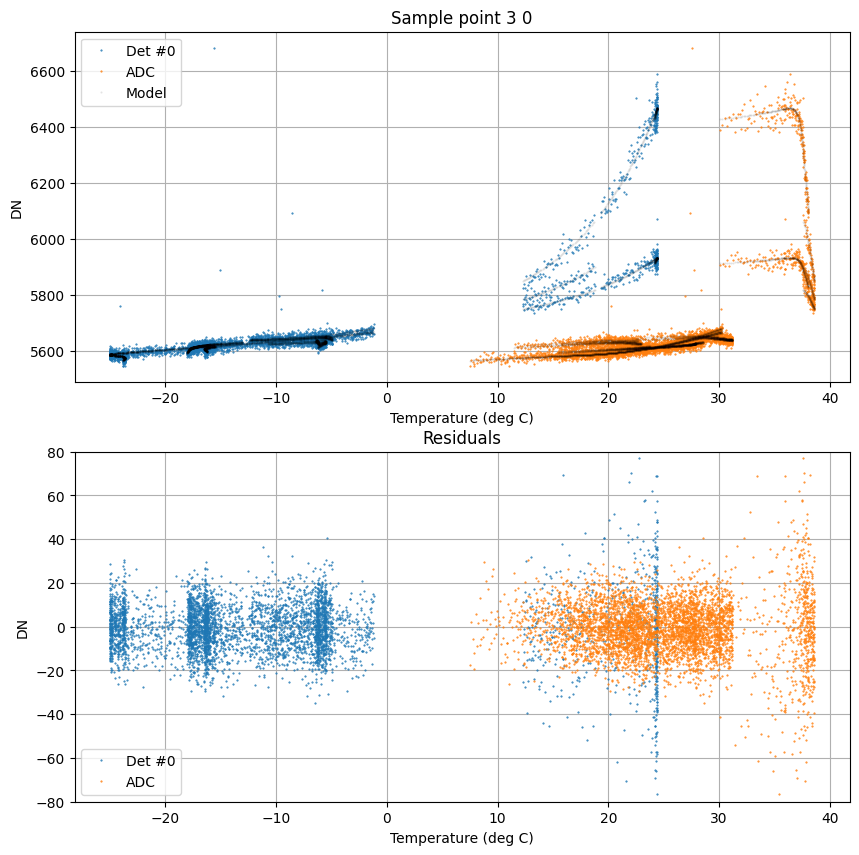

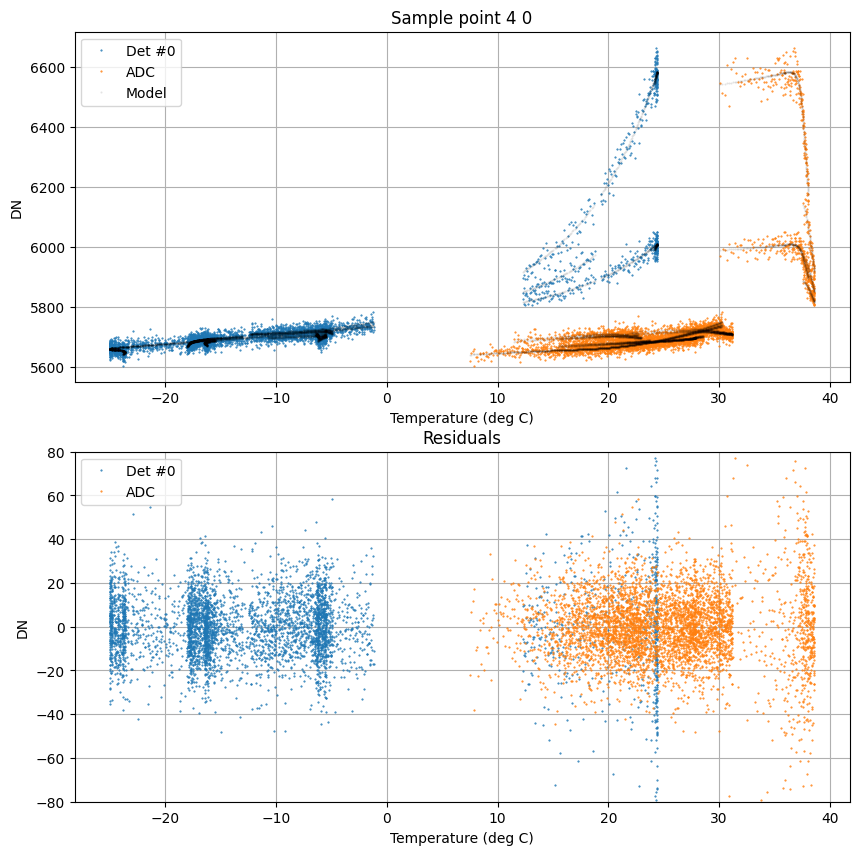

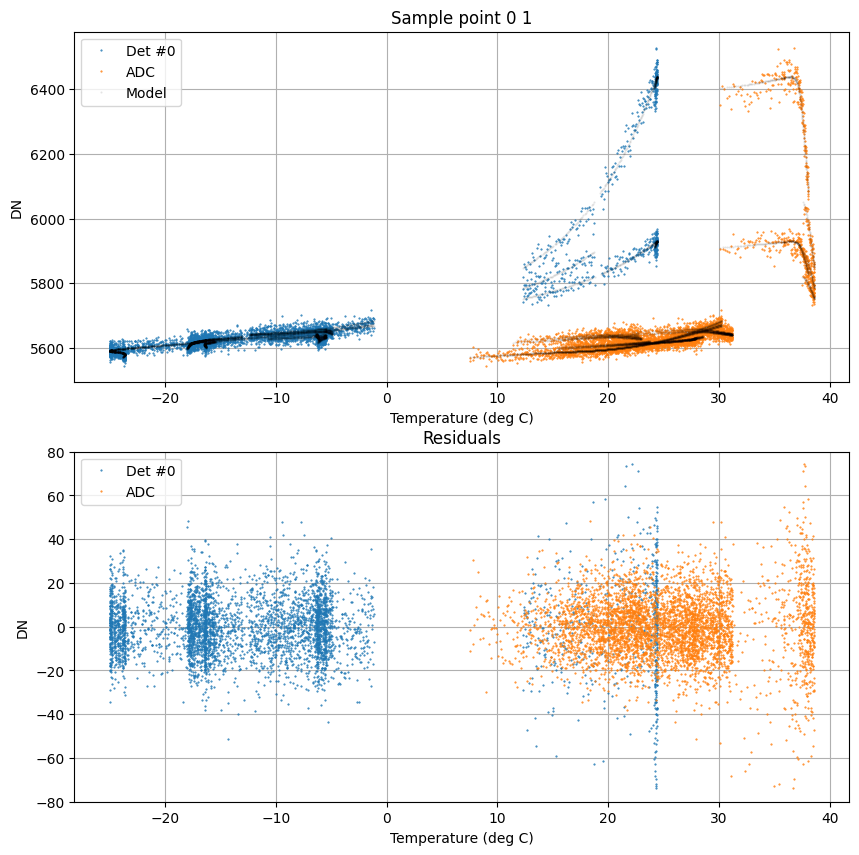

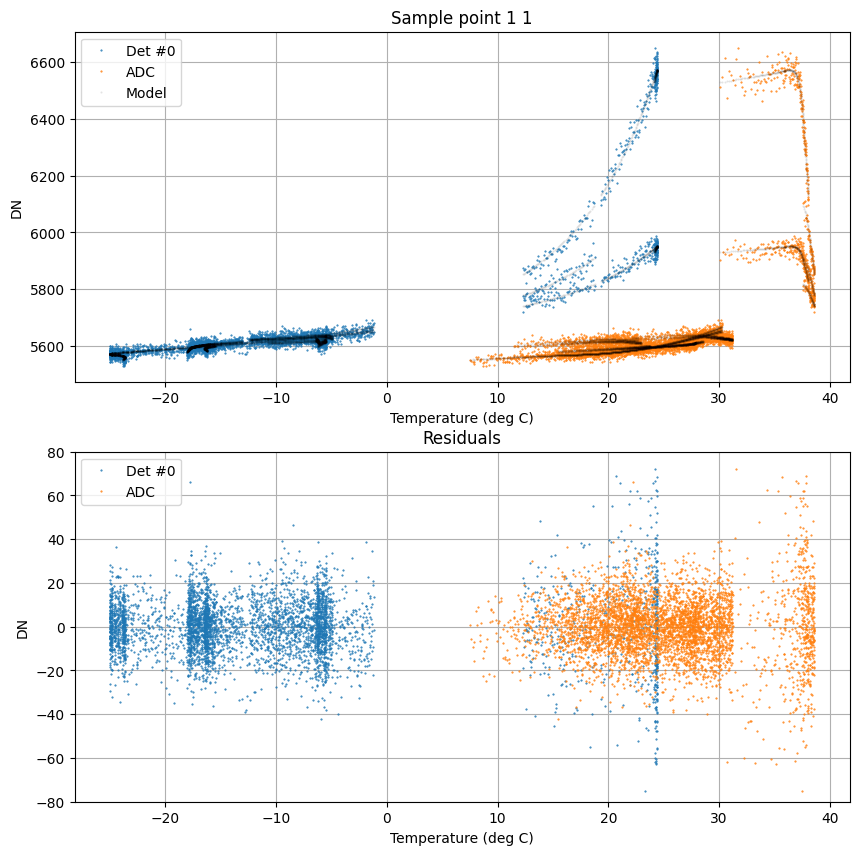

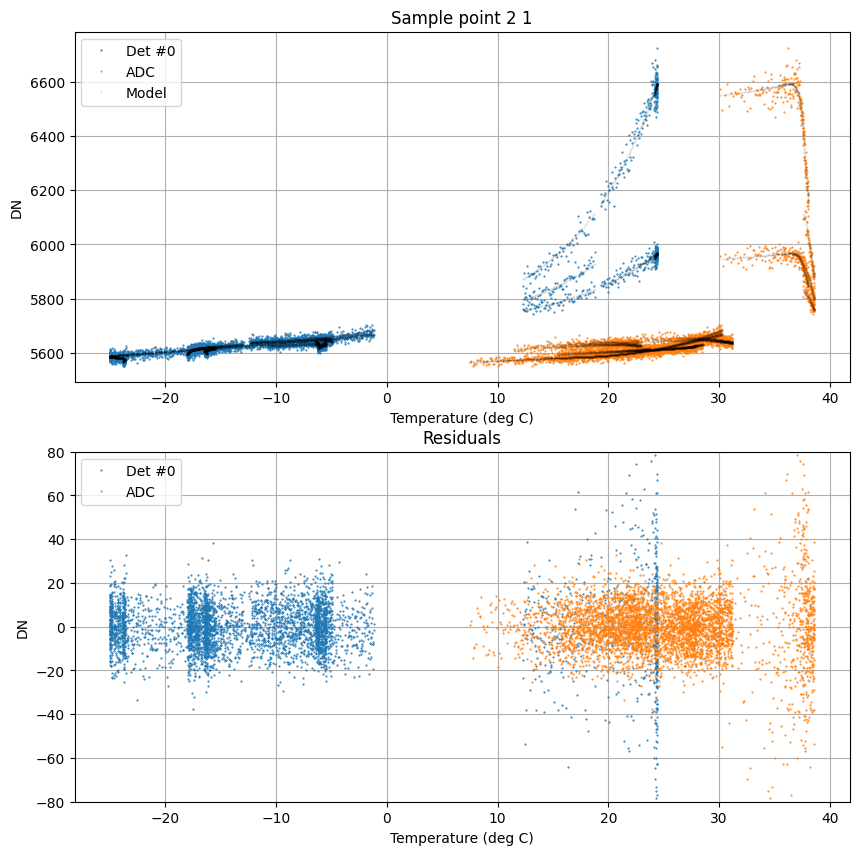

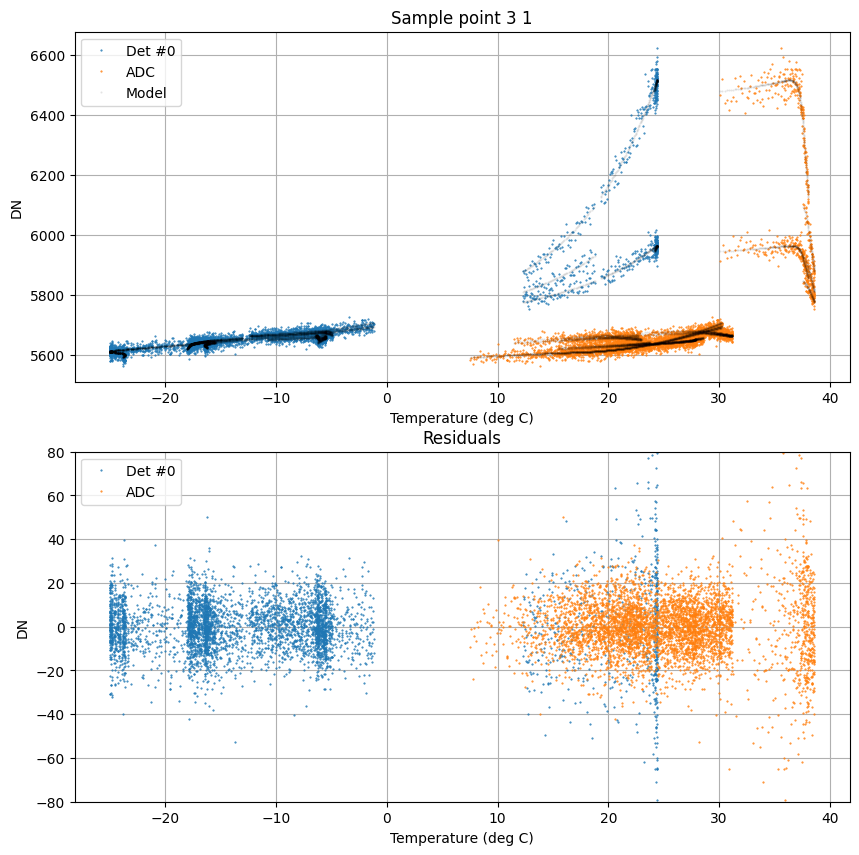

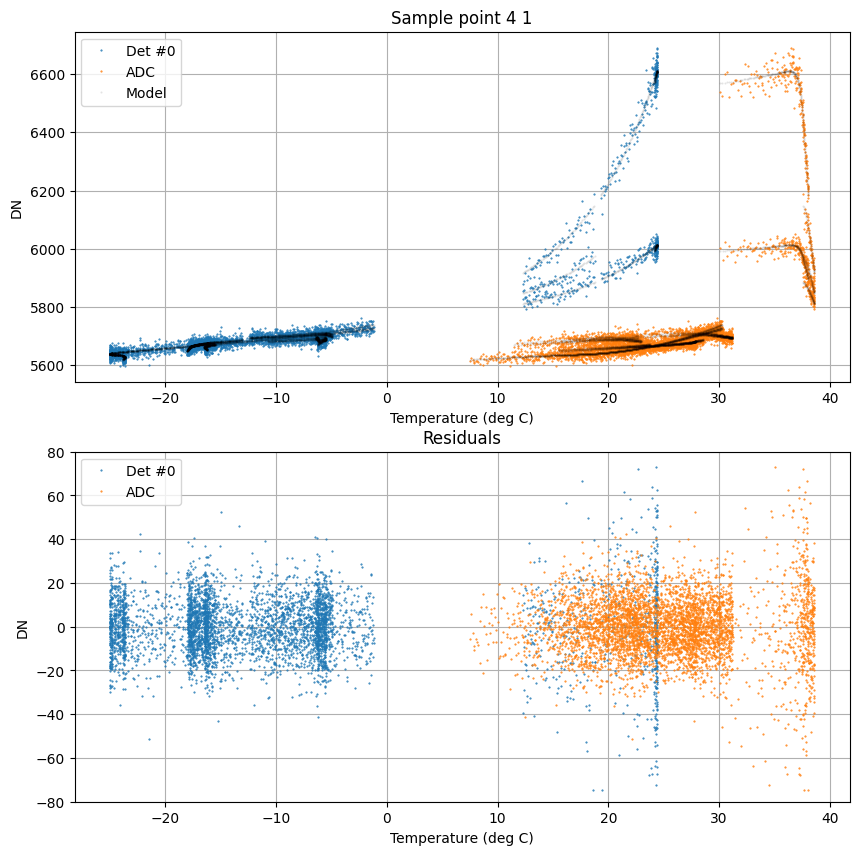

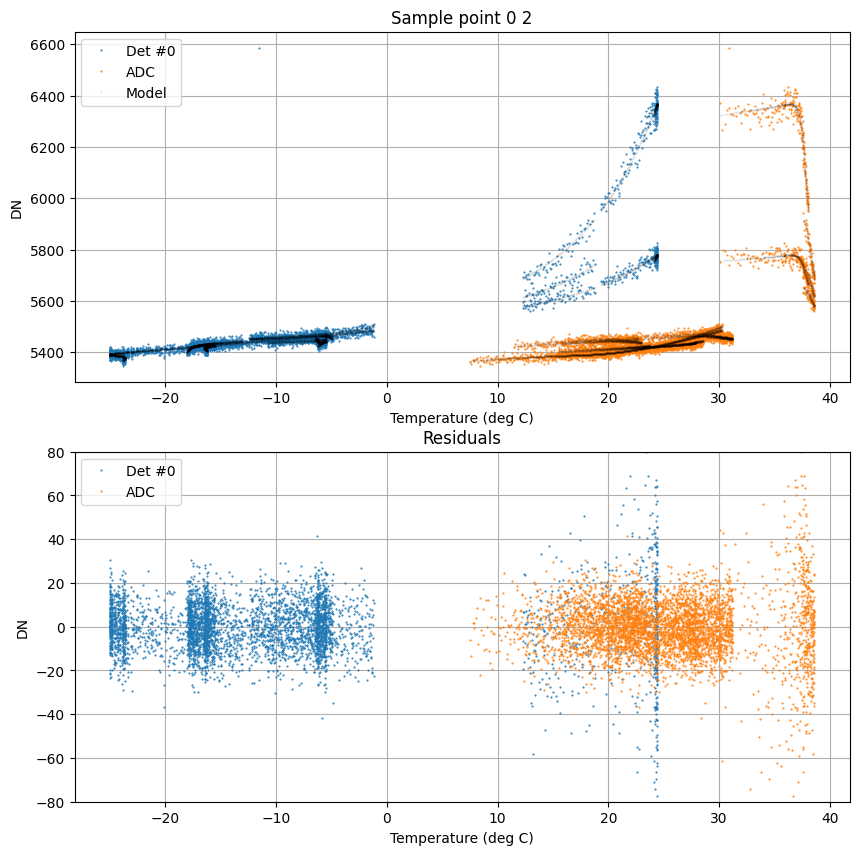

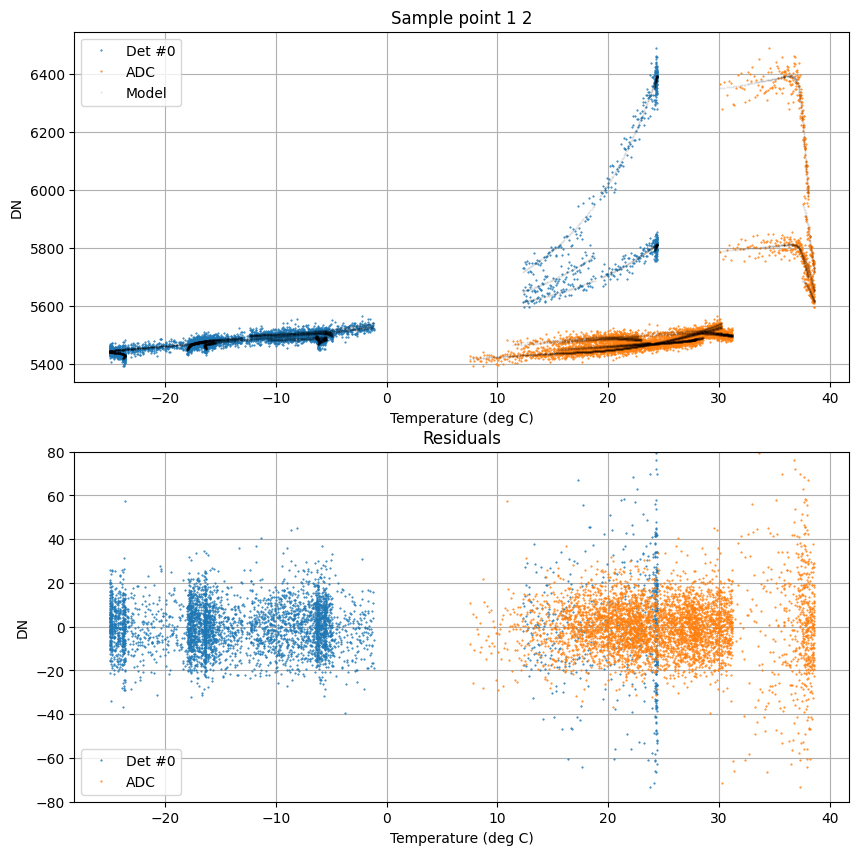

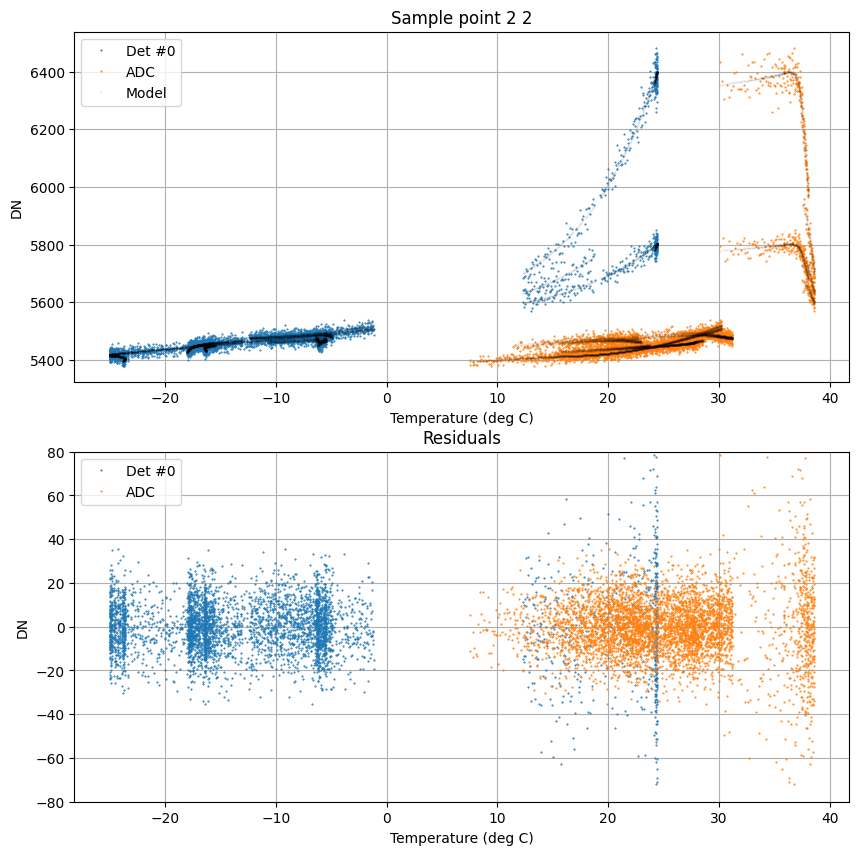

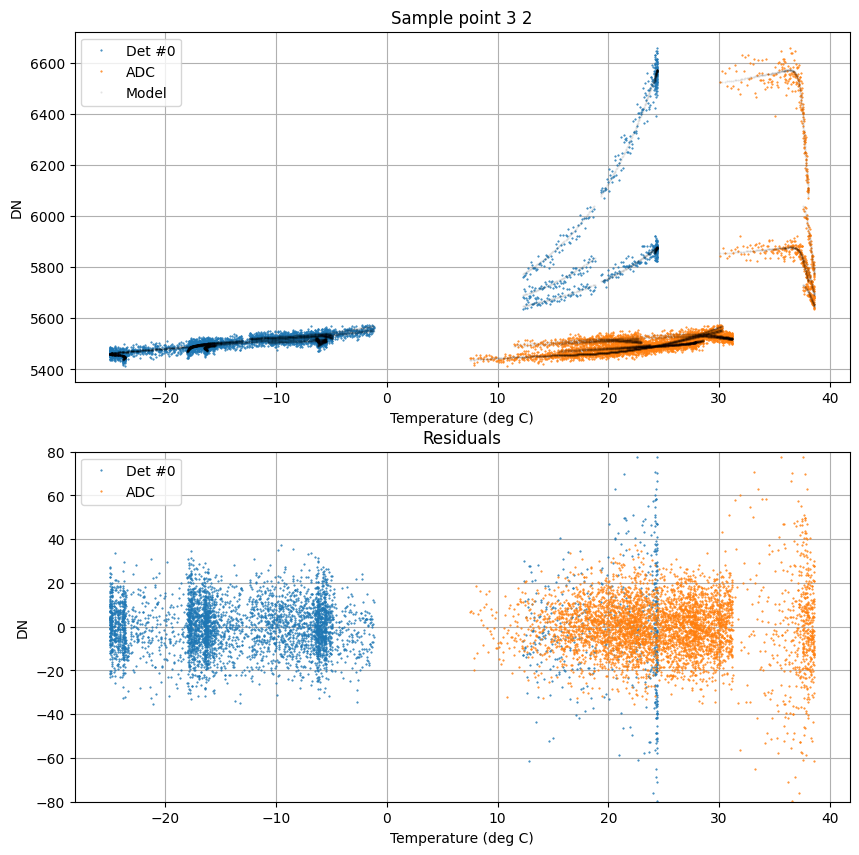

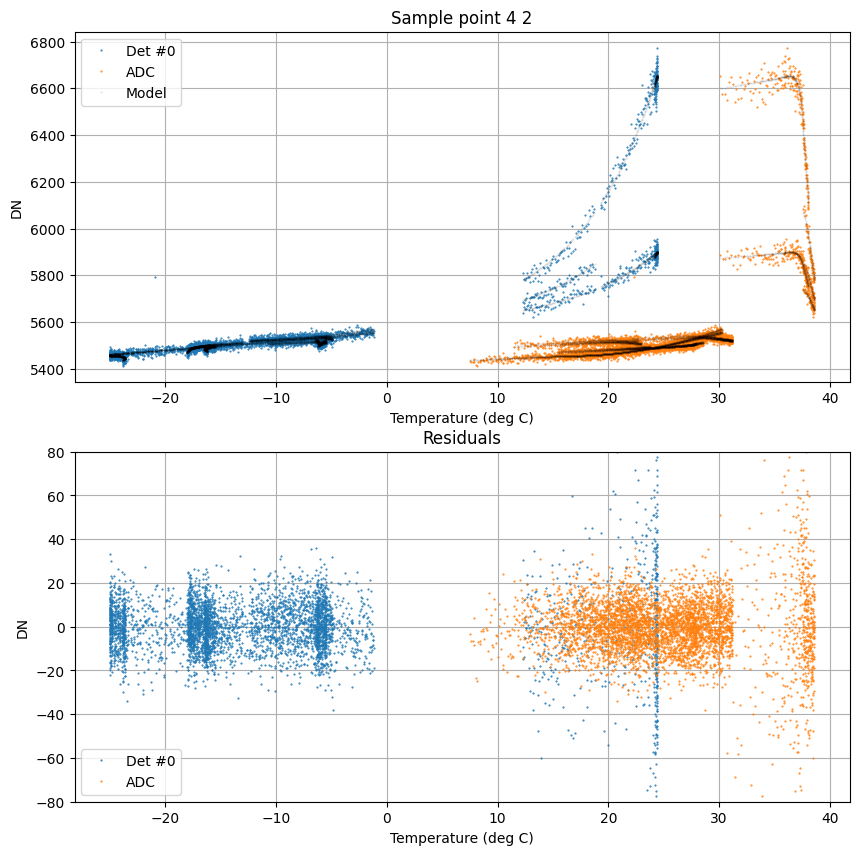

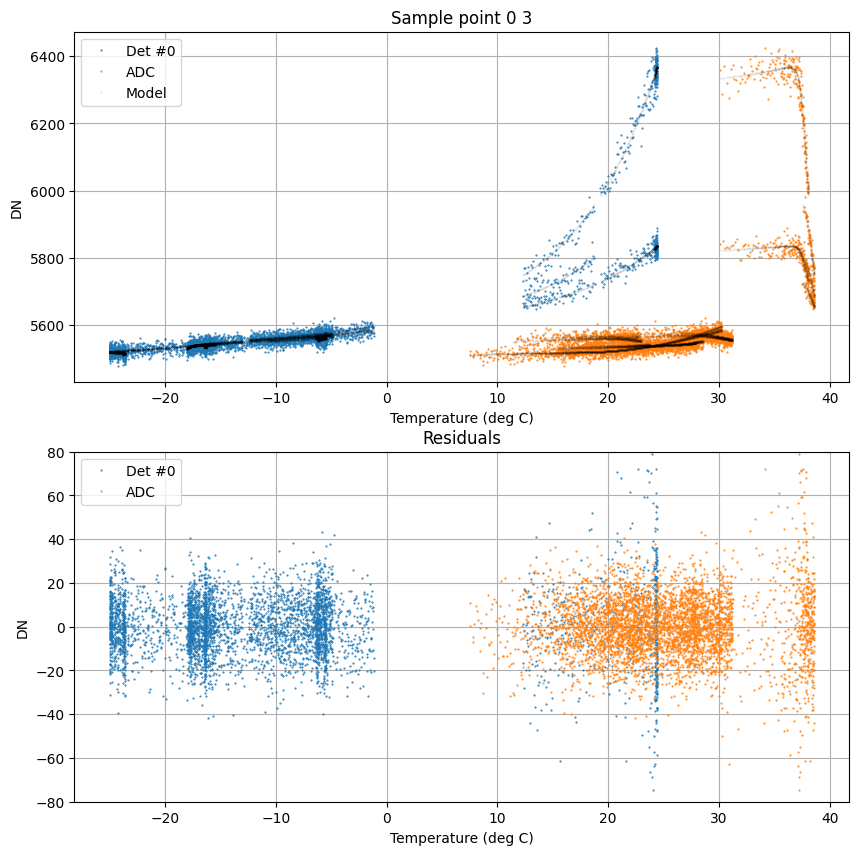

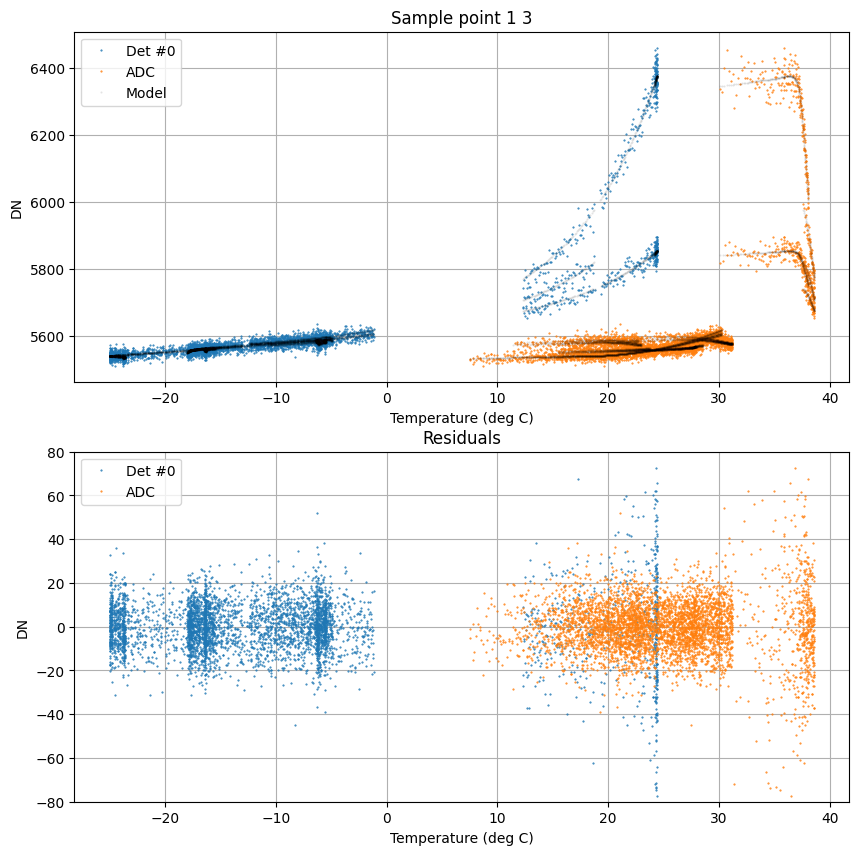

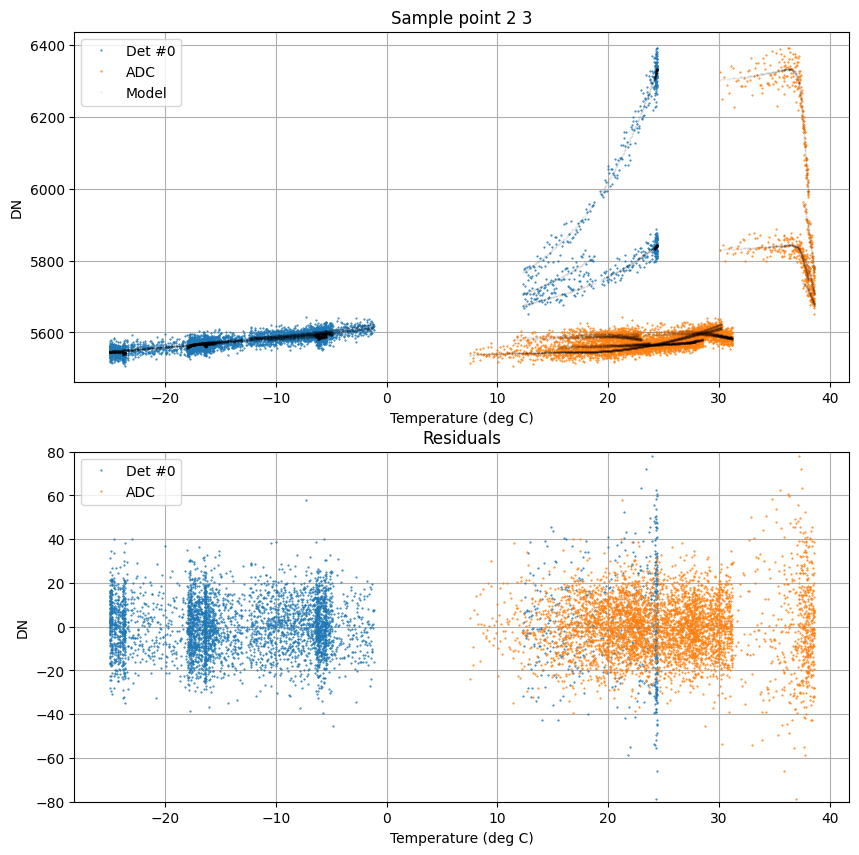

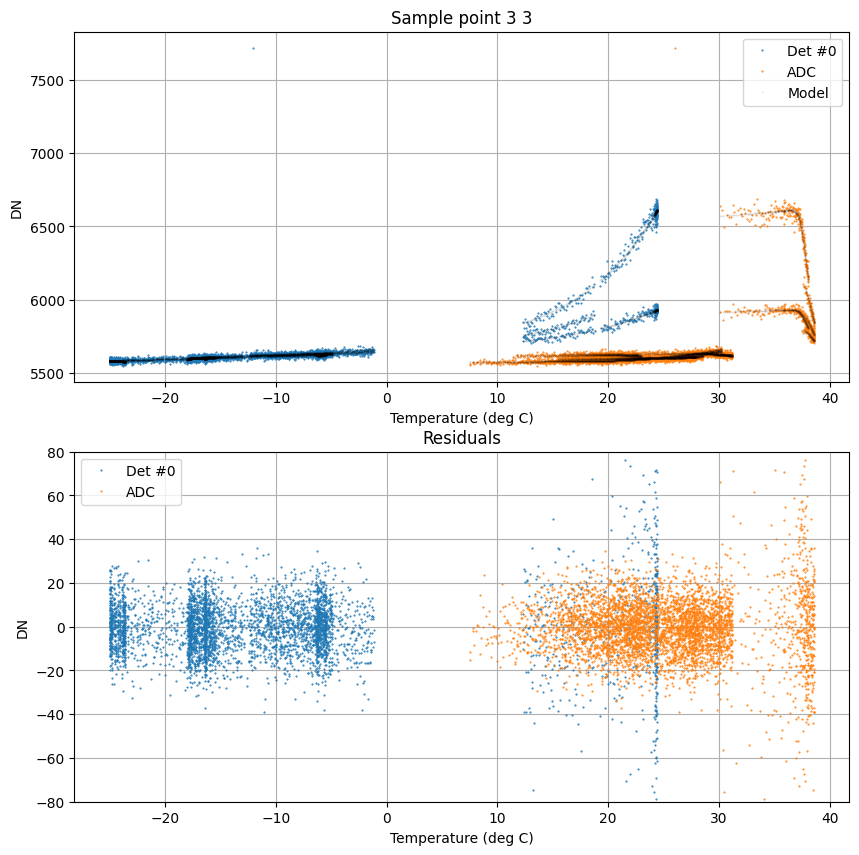

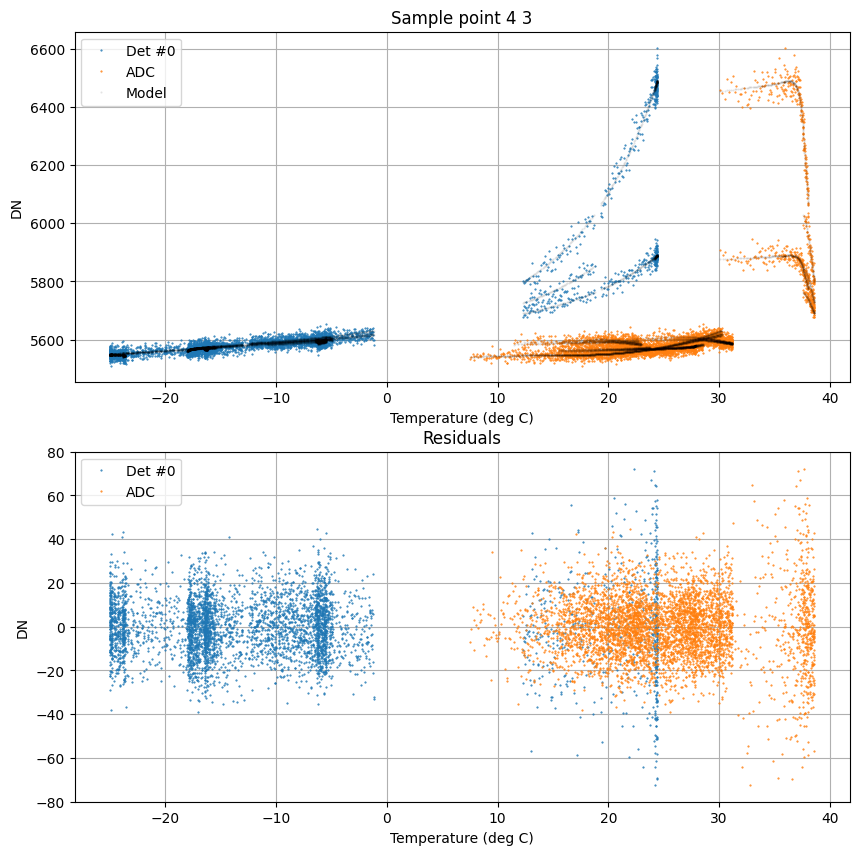

In [29]:
for j in range(subdata.shape[2]):
    for i in range(subdata.shape[1]):
        actuals = subdata[:, i, j]
        predicts = model(space3d, *params[:, i, j])
        
        fig = plt.figure(figsize=(10, 10))
        
        ax = fig.add_subplot(211)
        
        ax.plot(det0temp, actuals, '.', markersize=1, label='Det #0')
        ax.plot(thermadc, actuals, '.', markersize=1, label='ADC')
        
        ax.plot(det0temp, predicts, 'k.', markersize=1, alpha=0.1, label='Model')
        ax.plot(thermadc, predicts, 'k.', markersize=1, alpha=0.1, label='')
        
        ax.grid()
        
        ax.set_title(f"Sample point {i} {j}")
        ax.set_xlabel("Temperature (deg C)")
        ax.set_ylabel("DN")
        ax.legend()
        
        ax = fig.add_subplot(212)
        
        ax.plot(det0temp, actuals - predicts, '.', markersize=1, label='Det #0')
        ax.plot(thermadc, actuals - predicts, '.', markersize=1, label='ADC')

        ax.set_ylim(-80, 80)

        ax.grid()
        
        ax.set_title("Residuals")
        ax.set_xlabel("Temperature (deg C)")
        ax.set_ylabel("DN")
        ax.legend()

plt.show()

# Take a closer look at a single pixel

In [30]:
actuals = subdata[exp1250, 4, 3]
predicts = model(space3d[:, exp1250], *params[:, 4, 3])
deltas = actuals - predicts

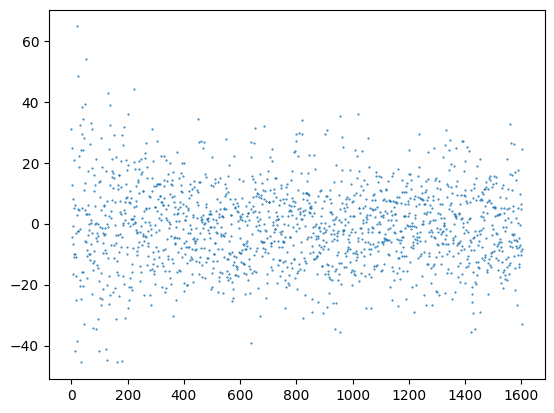

In [31]:
plt.plot(deltas, '.', markersize=1)
plt.show()

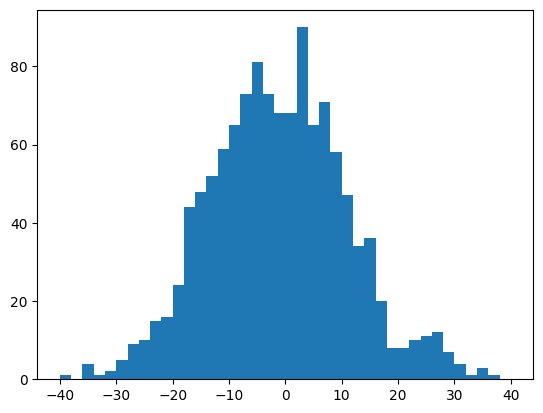

In [32]:
plt.hist(deltas[400:], bins = np.arange(-40, 41, 2))
plt.show()

In [33]:
# RMS
np.sqrt(np.mean((deltas[400:] - np.mean(deltas[400:])) ** 2))

np.float64(12.17022241962925)